In [1]:
import numpy as np
import WLCgreen as wlc
import matplotlib.pyplot as plt
#%matplotlib
import propagator 
import special as sp
from numba import jit

## 2 point

###  AA

\begin{align*}
\sum_{l}Res_{l}\int_{0}^{N}ds_{2}\int_{0}^{s_{2}}ds_{1}e^{\epsilon_{l}\left(s_{2}-s_{1}\right)} & =\sum_{l}Res_{l}\left(\frac{e^{N\epsilon}}{\epsilon^{2}}-\frac{1}{\epsilon^{2}}-\frac{N}{\epsilon}\right)
\end{align*}

In [2]:
# expl expansion methode
def IAAexplicit(N,lam0,lam,p1):
    eig=p1.eig
    res=p1.res
    out=0.0
    for l in range(0,len(eig)):
        eps=eig[l]
        R=res[l][lam0,lam]
        #out=out+2*R*((np.exp(N*eps)-1)/(eps**2)-N/eps)
        out=out+2*R*sp.expl(N*eps,2)/(eps**2)
    return out  

\[
\underset{AA}{I_{1}^{\left(2\right)}}\left(N\right)=\sum_{l_{1}}\frac{e^{\epsilon_{1}N}}{\epsilon_{1}^{2}}R_{1}+dG_{1}\left(0\right)+NG\left(0\right)
\]

In [3]:
# residue resum methode
def IAAresum(N,lam0,lam,p1):
    res=p1.res
    eig=p1.eig
    G0=p1.G0
    dG0=p1.dG0
    ORDEig=len(eig)
    out = 0.0
    for l in range(0,ORDEig):
        out=out+np.exp(eig[l]*N)*(eig[l]**-2)*res[l][lam0,lam]
        #out=out-res[l][lam0,lam]*(eig[l]**-2)
        #out=out-res[l][lam0,lam]*(N/eig[l])
        
    out=out+N*G0[lam0,lam]
    out=out+dG0[lam0,lam]
    return out*2

### AB

\[
\int_{Nf_{A}}^{N}ds_{2}\int_{0}^{Nf_{A}}ds_{1}\mathcal{G}\left(\left|s_{2}-s_{1}\right|\right)=\sum_{l=0}^{\infty}\frac{\left(e^{\epsilon_{l}Nf_{A}}-1\right)\left(e^{\epsilon_{l}N\left(1-f_{A}\right)}-1\right)}{\epsilon_{l}^{2}}R_1
\]

In [4]:
# Double Intigral Methode
def IABexplicit(N,fa,lam0,lam,p1):
    eig=p1.eig
    res=p1.res
    fb=1-fa
    out=0.0
    for l in range(0,len(eig)):
        eps=eig[l]
        R=res[l][lam0,lam]
        out=out+2*R*(sp.expl(N*fa*eps,1)*sp.expl(N*fb*eps,1))/(eps**2)
    return out   


\[
\underset{AB}{I_{1}^{\left(2\right)}}\left(N\right)=\sum_{l_{1}=0}^{\infty}R_{1}\frac{\left(e^{\epsilon_{1}N}-e^{Nf_{A}\epsilon_{1}}-e^{Nf_{B}\epsilon_{1}}\right)}{\epsilon_{1}^{2}}-dG_{1}
\]


In [5]:
# Resum methode
def IABresum(N,fa,lam0,lam,p1):
    eig=p1.eig
    res=p1.res
    dG0=p1.dG0
    fb=1-fa
    out=0.0
    for l in range(0,len(eig)):
        eps=eig[l]
        R=res[l][lam0,lam]
        out=out+2*R*(np.exp(N*eps) - np.exp(N*fa*eps) - np.exp(N*fb*eps))/(eps**2)
    out=out-2*dG0[lam0,lam]
    return out   

### Evaluate

In [6]:
nlam=3
ORDEig=25
d=3
mu=0

nkpts=500
K=np.logspace(-5,7,nkpts)
props=[] # list of propagators at each K
for ii in range(0,nkpts):
    name = ii
    props.append(propagator.propagator(name,K[ii],mu,nlam=nlam))

In [7]:
N=[0.1,1.0,10,100,1000,10000,100000]
ana=np.zeros((nkpts,len(N)),dtype=type(1+1j))
dub=np.zeros((nkpts,len(N)),dtype=type(1+1j))
for ii in range(0,nkpts):
    lam=0
    lam0=0
    for nn in range(0,len(N)):
        ana[ii,nn]=IAAresum(N[nn],lam0,lam,props[ii])
        dub[ii,nn]=IAAexplicit(N[nn],lam0,lam,props[ii])

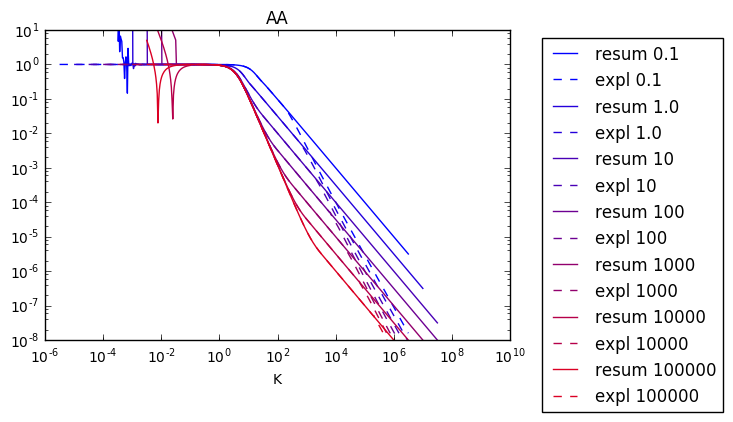

In [8]:
fig, ax = plt.subplots()
for ii in range(0,len(N)):
    col=float(ii)/len(N)
    ax.loglog(K.real*np.sqrt(N[ii]),abs(ana[:,ii])/(N[ii]**2),\
                color=[col, 0.0, 1-col],label='resum '+str(N[ii]))
    ax.loglog(K.real*np.sqrt(N[ii]),abs(dub[:,ii])/(N[ii]**2),'--',\
                color=[col, 0.0, 1-col],label='expl '+str(N[ii]))
ax.legend(bbox_to_anchor=(1.05,1),loc=2)
ax.set_xlabel('K')
ax.set_title('AA')
ax.set_ylim([10**-8,10**1])
plt.show()

In [9]:
N=[0.01,0.1,1.0,10,100]
ana=np.zeros((nkpts,len(N)),dtype=type(1+1j))
dub=np.zeros((nkpts,len(N)),dtype=type(1+1j))
fa=0.5
for ii in range(0,nkpts):
    lam=0
    lam0=0
    for nn in range(0,len(N)):
        ana[ii,nn]=IABresum(N[nn],fa,lam0,lam,props[ii])
        dub[ii,nn]=IABexplicit(N[nn],fa,lam0,lam,props[ii])

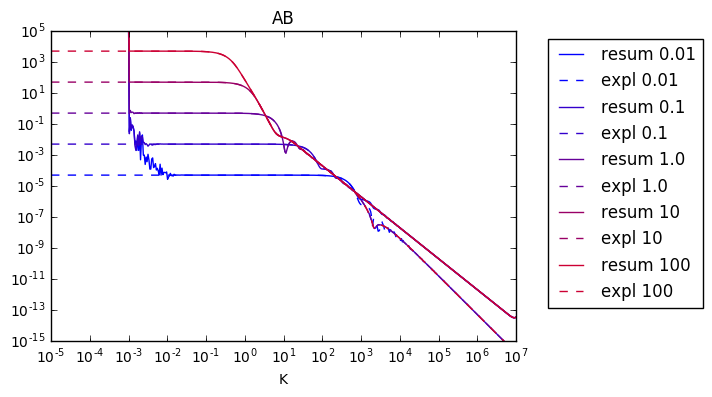

In [10]:
fig, ax = plt.subplots()
for ii in range(0,len(N)):
    col=float(ii)/len(N)
    ax.loglog(K.real,abs(ana[:,ii]),\
                color=[col, 0.0, 1-col],label='resum '+str(N[ii]))
    ax.loglog(K.real,abs(dub[:,ii]),'--',\
                color=[col, 0.0, 1-col],label='expl '+str(N[ii]))
ax.legend(bbox_to_anchor=(1.05,1),loc=2)
ax.set_xlabel('K')
ax.set_title('AB')
ax.set_ylim([10**-15,100000])
plt.show()

## 3 Point

### AAA

\begin{align*}
\underset{AAA}{I_{1,2}^{\left(3\right)}}\left(Nf_{A}\right)= & \sum_{l_{1},l_{2}}\left[Res_{1}\left(\epsilon_{1,l_{1}}\right)Res_{2}\left(\epsilon_{2,l_{2}}\right)f2\left(2,\epsilon_{1,l_{1}},\epsilon_{2,l_{2}},Nf_{A}\right)\right]\\
 & +Nf_{A}\mathcal{G}_{2}\left(0\right)\mathcal{G}_{1}\left(0\right)+\mathcal{G}'_{2}\left(0\right)\mathcal{G}_{1}\left(0\right)+\mathcal{G}_{2}\left(0\right)\mathcal{G}'_{1}\left(0\right)
\end{align*}

In [11]:
def IAAAresum(N,lam0,lam,p1,p2):
    out=0.0+0.0j
    for l1 in range(0,p1.ORDEig):
        for l2 in range(0,p2.ORDEig):
            eps1=p1.eig[l1]
            eps2=p2.eig[l2]
            R1=p1.res[l1][lam0,lam]
            R2=p2.res[l2][lam0,lam]
            
            out=out+R1*R2*sp.f2(2,eps1,eps2,N)
        
    out=out+N*p2.G0[lam0,lam]*p1.G0[lam0,lam]
    out=out+p2.dG0[lam0,lam]*p1.G0[lam0,lam]
    out=out+p1.dG0[lam0,lam]*p2.G0[lam0,lam]
    return out

In [12]:
def IAAAexplicit(N,lam0,lam,p1,p2):
    out=0
    tol=10**-6
    for l1 in range(0,p1.ORDEig):
        for l2 in range(0,p2.ORDEig):
            eps1=p1.eig[l1]
            eps2=p2.eig[l2]
            R1=p1.res[l1][lam0,lam]
            R2=p2.res[l2][lam0,lam]
            if abs((eps1-eps2)/(eps1+eps2)) > tol:
                out=out+R1*R2*((eps2**-2)*sp.expl(N*eps2,2)-\
                               (eps1**-2)*sp.expl(N*eps1,2))/(eps2-eps1)
            else:
                out=out+R1*R2*(-2*sp.expl(N*eps1,3)+N*eps1*sp.expl(N*eps1,2))/(eps1**3)
    return out

#### Old

In [13]:
def IAAAresumOld(N,lam0,lam,p1,p2):
    out=0.0+0.0j
    for l in range(0,p1.ORDEig):
        eps=p1.eig[l]
        R=p1.res[l][lam0,lam]
        G=p2.G_other(lam0,lam,p2,l)
        out=out+(eps**-2)*np.exp(eps*N)*R
        
    for l in range(0,p2.ORDEig):
        eps=p2.eig[l]
        R=p2.res[l][lam0,lam]
        G=p1.G_other(lam0,lam,p1,l)
        out=out+(eps**-2)*np.exp(eps*N)*R   
        
    out=out+N*p2.G0[lam0,lam]*p1.G0[lam0,lam]
    out=out+p2.dG0[lam0,lam]*p1.G0[lam0,lam]
    out=out+p1.dG0[lam0,lam]*p2.G0[lam0,lam]
    return out

### ABB

\begin{align*}
\underset{ABB}{I_{1,2}^{\left(3\right)}}\left(Nf_{A}\right)= & \sum_{l_{1},l_{2}}Res_{1}\left(\epsilon_{1,l_{1}}\right)Res_{2}\left(\epsilon_{2,l_{2}}\right)\left[\frac{e^{Nf_{A}\epsilon_{1}}}{\epsilon_{1}}f2\left(1,\epsilon_{1},\epsilon_{2},Nf_{B}\right)-f2\left(2,\epsilon_{1,l_{1}},\epsilon_{2,l_{2}},Nf_{B}\right)\right]\\
 & +\mathcal{G}_{1}\left(0\right)\sum_{l_{2}=0}^{\infty}Res_{2}\left(\epsilon_{2}\right)\frac{e^{Nf_{B}\epsilon_{2}}}{\epsilon_{2}^{2}}-\mathcal{G}{}_{2}\left(0\right)\sum_{l_{1}=0}^{\infty}Res_{1}\left(\epsilon_{1}\right)\frac{e^{Nf_{A}\epsilon_{1}}}{\epsilon_{1}^{2}}\\
 & -\mathcal{G}'_{1}\left(0\right)\mathcal{G}{}_{2}\left(0\right)
\end{align*}

In [13]:
def IABBresum(N,fa,lam0,lam,p1,p2):
    out=0.0+0.0j
    fb=1.0-fa
    for l1 in range(0,p1.ORDEig):
        for l2 in range(0,p2.ORDEig):
            e1=p1.eig[l1]
            e2=p2.eig[l2]
            R1=p1.res[l1][lam0,lam]
            R2=p2.res[l2][lam0,lam]
            
            out=out+R1*R2*(np.exp(N*fa*e1)*sp.f2(1,e1,e2,N*fb)/e1 \
                           - sp.f2(2,e1,e2,N*fb))
    
    temp=0.0
    for l2 in range(0,p2.ORDEig):     
        e2=p2.eig[l2]
        R2=p2.res[l2][lam0,lam]
        temp=temp+R2*np.exp(N*fb*e2)/(e2**2)
    out = out + temp*p1.G0[lam0,lam]
         
    temp=0.0
    for l1 in range(0,p1.ORDEig):     
        e1=p1.eig[l1]
        R1=p1.res[l1][lam0,lam]
        temp=temp+R1*np.exp(N*fa*e1)/(e1**2)
    out = out - temp*p2.G0[lam0,lam]
    
    out = out - p1.dG0[lam0,lam]*p2.G0[lam0,lam]
    return out

### Evaluate

In [14]:
nlam=5
ORDEig=10
d=3
mu=0

nkpts=100
K=np.logspace(-4,7,nkpts)
props1=[] # list of propagators at each K
props2=[] # list of propagators at each K
for ii in range(0,nkpts):

    name=ii
    props1.append( propagator.propagator(name,K[ii],mu,nlam=nlam) )

    name=ii+0.5
    props2.append( propagator.propagator(name,K[ii],mu,nlam=nlam) )

#### AAA

In [15]:
N=[0.01,0.1,1.0,10,100]
ana=np.zeros((nkpts,len(N)),dtype=type(1+1j))
dub=np.zeros((nkpts,len(N)),dtype=type(1+1j))
for ii in range(0,nkpts):
    lam=0
    lam0=0
    for nn in range(0,len(N)):
        ana[ii,nn]=IAAAresum(N[nn],lam0,lam,props1[ii],props2[ii])
        dub[ii,nn]=IAAAexplicit(N[nn],lam0,lam,props1[ii],props2[ii])

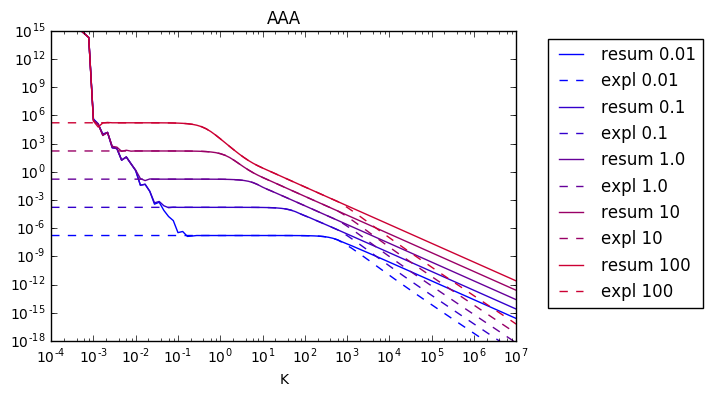

In [16]:
fig, ax = plt.subplots()
for ii in range(0,len(N)):
    col=float(ii)/len(N)
    ax.loglog(K.real,abs(ana[:,ii]),\
                color=[col, 0.0, 1-col],label='resum '+str(N[ii]))
    ax.loglog(K.real,abs(dub[:,ii]),'--',\
                color=[col, 0.0, 1-col],label='expl '+str(N[ii]))
ax.legend(bbox_to_anchor=(1.05,1),loc=2)
ax.set_xlabel('K')
ax.set_title('AAA')
ax.set_ylim([10**-18,10**15])
plt.show()

#### ABB

In [17]:
N=[0.01,0.1,1.0,10,100]
ana=np.zeros((nkpts,len(N)),dtype=type(1+1j))
dub=np.zeros((nkpts,len(N)),dtype=type(1+1j))
fa=0.4466
for ii in range(0,nkpts):
    lam=0
    lam0=0
    for nn in range(0,len(N)):
        ana[ii,nn]=IABBresum(N[nn],fa,lam0,lam,props1[ii],props2[ii])
        #dub[ii,nn]=IAAAexplicit(N[nn],lam0,lam,props1[ii],props2[ii])

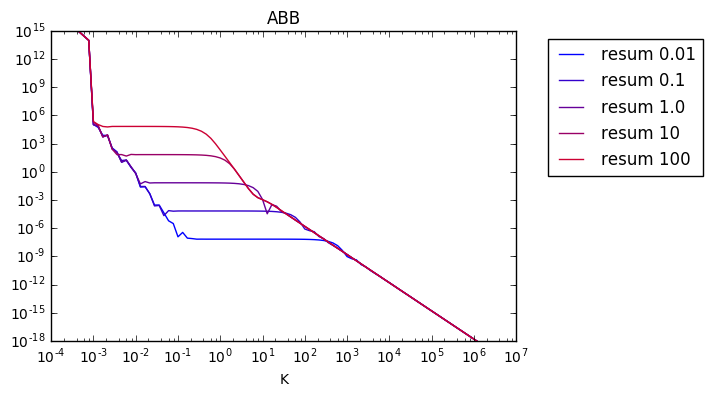

In [18]:
fig, ax = plt.subplots()
for ii in range(0,len(N)):
    col=float(ii)/len(N)
    ax.loglog(K.real,abs(ana[:,ii]),\
                color=[col, 0.0, 1-col],label='resum '+str(N[ii]))
    #ax.loglog(K.real,abs(dub[:,ii]),'--',\
    #            color=[col, 0.0, 1-col],label='expl '+str(N[ii]))
ax.legend(bbox_to_anchor=(1.05,1),loc=2)
ax.set_xlabel('K')
ax.set_title('ABB')
ax.set_ylim([10**-18,10**15])
plt.show()

## 4 point

### AAAA

\begin{align*}
\underset{AAAA}{I_{1,2,3}^{\left(4\right)}\left(Nf_{A}\right)}= & -\sum_{l_{1},l_{2},l_{3}}R_{1}R_{2}R_{3}f3\left(2,\epsilon_{1},\epsilon_{2},\epsilon_{3},Nf_{A}\right)\\
 & +Nf_{A}\mathcal{G}_{3}\mathcal{G}_{2}\mathcal{G}_{1}+\mathcal{G}'_{3}\mathcal{G}{}_{2}\mathcal{G}_{1}+\mathcal{G}_{3}\mathcal{G}'_{2}\mathcal{G}_{1}+\mathcal{G}_{3}\mathcal{G}_{2}\mathcal{G}'_{1}
\end{align*}

In [19]:
def IAAAAresum(N,fa,lam0,lam,p1,p2,p3,K0cuttoff=10**-9):
    if p2.K < K0cuttoff:
        if lam0==0 and lam==0:
            return IAAAAresumK2is0(N*fa,lam0,lam,p1,p3)
        #else:
        #    return 0+0j
    out=0.0+0.0j
    tol = 10**-15
    for l1 in range(0,p1.ORDEig):
        for l2 in range(0,p2.ORDEig):
            for l3 in range(0,p3.ORDEig):
                e1=p1.eig[l1]
                e2=p2.eig[l2]
                e3=p3.eig[l3]
                R1=p1.res[l1][lam0,lam]
                R2=p2.res[l2][lam0,lam]
                R3=p3.res[l3][lam0,lam]
                #if abs(e2)<10**-7:
                #    print('epsilon of zero incountered')
                #    print('e1',e1,'e2',e2,'e3',e3)
                #    print('l1',l1,'l2',l2,'l3',l3)
                temp= - R1*R2*R3*sp.f3(2,e1,e2,e3,N*fa)
                out=out+temp
                if abs(temp/(out+tol))<tol:
                    break
    
    G1=p1.G0[lam0,lam]
    G2=p2.G0[lam0,lam]
    G3=p3.G0[lam0,lam]
    dG1=p1.dG0[lam0,lam]
    dG2=p2.dG0[lam0,lam]
    dG3=p3.dG0[lam0,lam]
    
    out = out + N*fa*G1*G2*G3 + dG1*G2*G3 + G1*dG2*G3 + G1*G2*dG3
    return out

\[
\sum_{l_{1},l_{3}}R{}_{1}R{}_{3}f2\left(3,\epsilon_{1},\epsilon_{3},Nf_{A}\right)+G_{1}d^{2}G_{3}+dG_{1}dG_{3}+d^{2}G_{1}G_{3}+Nf_{A}G_{1}dG_{3}+Nf_{A}dG_{1}G_{3}+\frac{N^{2}f_{A}^{2}}{2}G_{1}G_{3}
\]

In [20]:
def IAAAAresumK2is0(N,lam0,lam,p1,p3):
    out=0.0+0.0j
    for l1 in range(0,p1.ORDEig):
        for l3 in range(0,p3.ORDEig): 
            e1=p1.eig[l1]
            e3=p1.eig[l3]
            R1=p1.res[l1][lam0,lam]
            R3=p3.res[l3][lam0,lam]
            
            out=out+R1*R3*sp.f2(3,e1,e3,N)
            
    G1=p1.G0[lam0,lam]
    G3=p3.G0[lam0,lam]
    dG1=p1.dG0[lam0,lam]
    dG3=p3.dG0[lam0,lam]    
    
    #This look can be replaced by next derivative
    ddG1=0.0
    for l1 in range(0,p1.ORDEig):
        e1=p1.eig[l1]
        R1=p1.res[l1][lam0,lam]
        ddG1=ddG1-R1/(e1**3) 
       
    #This look can be replaced by next derivative
    ddG3=0.0
    for l3 in range(0,p3.ORDEig):
        e3=p3.eig[l3]
        R3=p3.res[l3][lam0,lam]
        ddG3=ddG3-R3/(e3**3) 
    
    out=out+G1*ddG3 + dG1*dG3 + ddG1*G3 + \
        N*G1*dG3 + N*dG1*G3+0.5*N*N*G1*G3

    return out

In [21]:
def case1(e1,e2,e3,N):
    e3,e2,e1 = sp.arrange(e1,e2,e3)
    tol=10**-6
    if abs(e2-e3)>tol:
        out=-( (e2-e3)*sp.expl(N*e1,2)/(e1**2) + \
               (e3-e1)*sp.expl(N*e2,2)/(e2**2) + \
               (e1-e2)*sp.expl(N*e3,2)/(e3**2) )/ \
             ((e1-e2)*(e2-e3)*(e3-e1))
    elif min(abs(e1-e2),abs(e3-e1)) > tol:
        out = (-N*e2*sp.expl(N*e2,3)*e1**3 + \
               2*sp.expl(N*e2,4)*e1**3 + sp.expl(N*e1,4)*e2**3 \
               - 3*sp.expl(N*e2,4)*e1**2*e2 +  N*e2*sp.expl(N*e2,3)*e1**2*e2)/\
              (e1**4*e2**3  - 2*e1**3*e2**4 + e1**2*e2**5)
    else:
        out = (-6*sp.expl(N*e1,4)-(N*e1)**2*sp.expl(N*e1,2)+\
               4*N*e1*sp.expl(N*e1,3))/(2*e1**4)
    return out

In [22]:
def IAAAAexplicit(N,lam0,lam,p1,p2,p3):
    out=0.0+0.0j
    tol = 10**-15
    for l1 in range(0,p1.ORDEig):
        for l2 in range(0,p2.ORDEig):
            for l3 in range(0,p3.ORDEig):
                e1=p1.eig[l1]
                e2=p2.eig[l2]
                e3=p3.eig[l3]
                R1=p1.res[l1][lam0,lam]
                R2=p2.res[l2][lam0,lam]
                R3=p3.res[l3][lam0,lam]
                out=out+R1*R2*R3*case1(e1,e2,e3,N)
    return out

### AAAB

\begin{align*}
\underset{AAAB}{I_{1,2,3}^{\left(4\right)}\left(N\right)}= & \sum_{l_{1},l_{2},l_{3}}R{}_{1}R{}_{2}R{}_{3}\left[f3\left(2,\epsilon_{1},\epsilon_{2},\epsilon_{3},Nf_{A}\right)-\frac{e^{Nf_{B}\epsilon_{3}}}{\epsilon_{3}}f3\left(1,\epsilon_{1},\epsilon_{2},\epsilon_{3},Nf_{A}\right)\right]\\
 & +\mathcal{G}_{3}\sum_{l_{1},l_{2}}R{}_{1}R{}_{2}f2\left(2,\epsilon_{1},\epsilon_{2},Nf_{A}\right)\\
 & -\mathcal{G}_{1}\mathcal{G}_{2}\sum_{l_{3}}R_{3}\frac{e^{Nf_{B}\epsilon_{3}}}{\epsilon_{3}^{2}}\\
 & -\mathcal{G}_{1}\mathcal{G}_{2}\mathcal{G}'_{3}
\end{align*}

In [23]:
#@jit#(nopython=True)
def IAAABresum(N,fa,lam0,lam,p1,p2,p3,K0cuttoff=10**-9):
    if p2.K < K0cuttoff and lam0==0 and lam==0:
        return IAAABresumK2is0(N,fa,lam0,lam,p1,p3)
    fb=1.0-fa
    out=0.0+0.0j
    tol = 10**-15
    for l1 in range(0,p1.ORDEig):
        e1=p1.eig[l1]
        R1=p1.res[l1][lam0,lam]
        for l2 in range(0,p2.ORDEig):
            e2=p2.eig[l2]
            R2=p2.res[l2][lam0,lam]
            for l3 in range(0,p3.ORDEig):
                e3=p3.eig[l3]
                R3=p3.res[l3][lam0,lam]

                temp= R1*R2*R3*( sp.f3(2,e1,e2,e3,N*fa) -\
                                     np.exp(N*fb*e3)*sp.f3(1,e1,e2,e3,N*fa)/e3 )
                out=out+temp
                if abs(temp/(out+tol))<tol:
                    break

    G1=p1.G0[lam0,lam]
    G2=p2.G0[lam0,lam]
    G3=p3.G0[lam0,lam]          
                
    temp=0.0
    for l1 in range(0,p1.ORDEig):
        for l2 in range(0,p2.ORDEig):
            e1=p1.eig[l1]
            e2=p2.eig[l2]
            R1=p1.res[l1][lam0,lam]
            R2=p2.res[l2][lam0,lam]   
            temp=temp+R1*R2*sp.f2(2,e1,e2,N*fa)
    out=out+temp*G3
            
    temp=0.0    
    for l3 in range(0,p3.ORDEig):
        e3=p3.eig[l3]
        R3=p3.res[l3][lam0,lam]
        temp=temp+R3*np.exp(N*fb*e3)/(e3**2)
    out=out-temp*G1*G2
    
    out = out - G1*G2*p3.dG0[lam0,lam] 
    return out

\begin{align*}
\underset{AAAB}{I_{1,2,3}^{\left(4\right)}\left(N\right)}= & \sum_{l_{1},l_{3}}R{}_{1}R{}_{3}f2\left(2,\epsilon_{1}\epsilon_{3},Nf_{A}\right)\frac{\exp\left(Nf_{B}\epsilon_{3}-1\right)}{\epsilon_{3}}\\
 & -G_{1}\sum_{l_{3}}R{}_{3}\frac{e^{Nf_{B}\epsilon_{3}}\left(1+Nf_{A}\epsilon_{3}\right)}{\epsilon_{3}^{3}}-dG_{1}\sum_{l_{3}}R{}_{3}\frac{e^{Nf_{B}\epsilon_{3}}}{\epsilon_{3}^{2}}\\
 & -G_{1}d^{2}G_{3}-dG_{1}dG_{3}-Nf_{A}G_{1}dG_{3}
\end{align*}

In [24]:
def IAAABresumK2is0(N,fa,lam0,lam,p1,p3):
    fb=1.0-fa
    out=0.0+0.0j
    for l1 in range(0,p1.ORDEig):
        for l3 in range(0,p3.ORDEig): 
            e1=p1.eig[l1]
            e3=p1.eig[l3]
            R1=p1.res[l1][lam0,lam]
            R3=p3.res[l3][lam0,lam]
            
            out=out+R1*R3*sp.f2(2,e1,e3,N*fa)*(np.exp(N*fb*e3)-1)/e3
    
    G1=p1.G0[lam0,lam]
    dG1=p1.dG0[lam0,lam]
    dG3=p3.dG0[lam0,lam]   
    
    for l3 in range(0,p3.ORDEig):
        e3=p3.eig[l3]
        R3=p3.res[l3][lam0,lam]
        out=out-G1*R3*np.exp(N*fb*e3)*(1+N*fa*e3)/(e3**3)
        out=out-dG1*R3*np.exp(N*fb*e3)/(e3**2)
       
    #This look can be replaced by next derivative
    ddG3=0.0
    for l3 in range(0,p3.ORDEig):
        e3=p3.eig[l3]
        R3=p3.res[l3][lam0,lam]
        ddG3=ddG3-R3/(e3**3) 
    
    out=out-G1*ddG3-dG1*dG3-N*fa*G1*dG3

    return out

### AABB

\begin{align*}
\underset{AABB}{I_{1,2,3}^{\left(4\right)}\left(N\right)}= & \sum_{l_{1},l_{2},l_{3}}R{}_{1}R{}_{2}R{}_{3}f\left(1,\epsilon_{1},\epsilon_{2},Nf_{A}\right)f\left(1,\epsilon_{2},\epsilon_{3},Nf_{B}\right)\\
 & -\mathcal{G}_{3}\sum_{l_{1},l_{2}}R{}_{1}R{}_{2}f\left(2,\epsilon_{1},\epsilon_{2},Nf_{A}\right)-\mathcal{G}_{1}\sum_{l_{2},l_{3}}R{}_{2}R{}_{3}f\left(2,\epsilon_{2},\epsilon_{3},Nf_{B}\right)\\
 & +\mathcal{G}_{2}\mathcal{G}_{3}\sum_{l_{1}}R_{1}\frac{e^{Nf_{A}\epsilon_{1}}}{\epsilon_{1}^{2}}+\mathcal{G}_{1}\mathcal{G}_{2}\sum_{l_{3}}R_{3}\frac{e^{Nf_{B}\epsilon_{3}}}{\epsilon_{3}^{2}}\\
 & -\mathcal{G}_{1}\mathcal{G}'_{2}\mathcal{G}_{3}
\end{align*}

In [25]:
def IAABBresum(N,fa,lam0,lam,p1,p2,p3,K0cuttoff=10**-9):
    if p2.K < K0cuttoff and lam0==0 and lam==0:
        return IAABBresumK2is0(N,fa,lam0,lam,p1,p3)
    fb=1.0-fa
    out=0.0+0.0j
    tol = 10**-15
    for l1 in range(0,p1.ORDEig):
        for l2 in range(0,p2.ORDEig):
            for l3 in range(0,p3.ORDEig):
                e1=p1.eig[l1]
                e2=p2.eig[l2]
                e3=p3.eig[l3]
                R1=p1.res[l1][lam0,lam]
                R2=p2.res[l2][lam0,lam]
                R3=p3.res[l3][lam0,lam]

                temp= R1*R2*R3*( sp.f2(1,e1,e2,N*fa)*sp.f2(1,e2,e3,N*fb) )
                out=out+temp
                if abs(temp/(out+tol))<tol:
                    break
    G1=p1.G0[lam0,lam]
    G2=p2.G0[lam0,lam]
    G3=p3.G0[lam0,lam]
           
    temp=0.0
    for l1 in range(0,p1.ORDEig):
        for l2 in range(0,p2.ORDEig):
            e1=p1.eig[l1]
            e2=p2.eig[l2]
            R1=p1.res[l1][lam0,lam]
            R2=p2.res[l2][lam0,lam]   
            temp=temp+R1*R2*sp.f2(2,e1,e2,N*fa)
    out=out-temp*G3

    temp=0.0
    for l2 in range(0,p2.ORDEig):
        for l3 in range(0,p3.ORDEig):
            e3=p3.eig[l3]
            e2=p2.eig[l2]
            R3=p3.res[l3][lam0,lam]
            R2=p2.res[l2][lam0,lam]   
            temp=temp+R2*R3*sp.f2(2,e2,e3,N*fb)
    out=out-temp*G1    

    temp=0.0    
    for l1 in range(0,p1.ORDEig):
        e1=p1.eig[l1]
        R1=p1.res[l1][lam0,lam]
        temp=temp+R1*np.exp(N*fa*e1)/(e1**2)
    out=out+temp*G2*G3    
    
    temp=0.0    
    for l3 in range(0,p3.ORDEig):
        e3=p3.eig[l3]
        R3=p3.res[l3][lam0,lam]
        temp=temp+R3*np.exp(N*fb*e3)/(e3**2)
    out=out+temp*G1*G2
    
    out = out - G1*p2.dG0[lam0,lam]*G3
    return out

\[
\underset{AABB}{I_{1,2,3}^{\left(4\right)}\left(N\right)}=\underset{AA}{I_{1}^{\left(2\right)}}\left(N\right)\underset{BB}{I_{3}^{\left(2\right)}}\left(N\right)
\]

In [26]:
def IAABBresumK2is0(N,fa,lam0,lam,p1,p3):
    fb=1.0-fa
    out=IAAresum(N*fa,lam0,lam,p1)*IAAresum(N*fb,lam0,lam,p3)
    return out

### Evaluate

In [27]:
nlam=5
ORDEig=25
d=3
mu=0

nkpts=100
K=np.logspace(-2,5,nkpts)
props1=[] # list of propagators at each K
props2=[] # list of propagators at each K
props3=[] # list of propagators at each K
for ii in range(0,nkpts):

    name=ii
    props1.append( propagator.propagator(name,1.0*K[ii],mu,nlam=nlam) )

    name=ii+0.5
    props2.append( propagator.propagator(name,K[ii],mu,nlam=nlam) )
    
    name=ii+0.25
    props3.append( propagator.propagator(name,1.0*K[ii],mu,nlam=nlam) )

In [28]:
N=[0.001,0.01,0.1,1.0,10,100,1000]
ana=np.zeros((nkpts,len(N)),dtype=type(1+1j))
dub=np.zeros((nkpts,len(N)),dtype=type(1+1j))
fa=0.4466
for ii in range(0,nkpts):
    lam=0
    lam0=0
    
    for nn in range(0,len(N)):
        ana[ii,nn]=IAABBresum(N[nn],fa,lam0,lam,props1[ii],props2[ii],props3[ii])
        #dub[ii,nn]=IAAAAexplicit(N[nn],lam0,lam,props1[ii],props2[ii],props3[ii])

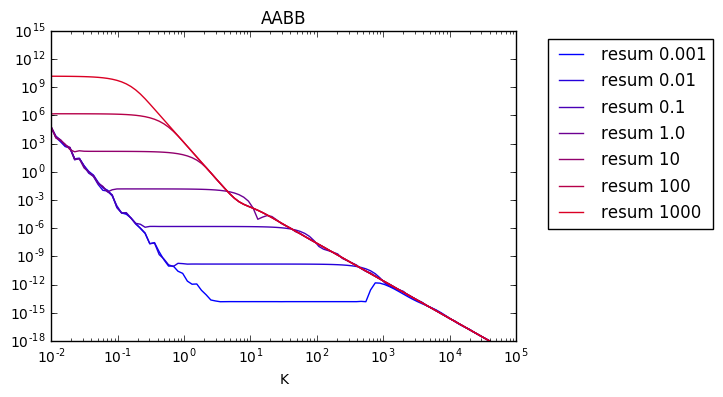

In [29]:
fig, ax = plt.subplots()
for ii in range(0,len(N)):
    col=float(ii)/len(N)
    ax.loglog(K.real,abs(ana[:,ii]).real,\
                color=[col, 0.0, 1-col],label='resum '+str(N[ii]))
    #ax.loglog(K.real,abs(dub[:,ii]),'--',\
    #            color=[col, 0.0, 1-col],label='expl '+str(N[ii]))
ax.legend(bbox_to_anchor=(1.05,1),loc=2)
ax.set_xlabel('K')
ax.set_title('AABB')
ax.set_ylim([10**-18,10**15])
plt.show()